# Introduction
In this notebook I scrape [eigenfactor.org](eigenfactor.org) for journal rankings and compute inequality statistics.

The notebook is focussed on economics but in the last section I compare economics to other social sciences.

Code has not been checked for errors.

### Inititial stuff

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('notebook')
%matplotlib inline
import requests
from bs4 import BeautifulSoup

# Scrape data

In [183]:
def get_data(year,field):
    url = "http://eigenfactor.org/projects/journalRank/rankings.php?search="+field+"&year=%.0f&searchby=isicat&orderby=ArticleInfluence"%year
    r = requests.get(url)
    html = BeautifulSoup(r.content)
    names = []
    for h in html.find_all('div', class_ = "journal")[1:]:
        names += [str(h).split('>')[1].split('<')[0]]
    ef =[]
    for h in html.find_all('div', class_ = "EF")[1:]:
        ef += [float(str(h).split('>')[1].split('<')[0].replace("&lt;",''))]

    df_temp = pd.DataFrame([names,ef],index=['Name','EF']).T
    df_temp['year'] = year
    return df_temp

In [184]:
df = pd.DataFrame()

for y in range(1997,2015+1):

    
    df_temp = get_data(y,"GY")
    df_temp['year'] = y
    
    df = df.append(df_temp)

# Analysis

In [186]:
y_list_short = [1999,2010,2015]

In [187]:
rank_var = "EF"

## Lorenz curves

In [188]:
def lorenz(X_in):
    X = np.sort(X_in)
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    X_lorenz[0], X_lorenz[-1]
    X=[i/len(X) for i in range(len(X)+1)]
    return X,X_lorenz

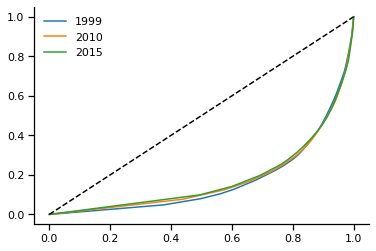

In [189]:
fig,ax = plt.subplots()
for y in y_list_short :
    df_temp = df[df['year']==y]
    x,l = lorenz(df_temp[rank_var].values)
    ax.plot(x,l,label=y)
sns.despine()
ax.plot([0,1],[0,1],color='k',ls='--')
ax.legend(frameon=False)

# Quantile plots

In [190]:
eval_range = [i/100 for i in range(0,101)]

Text(0.5, 0, 'Quantile')

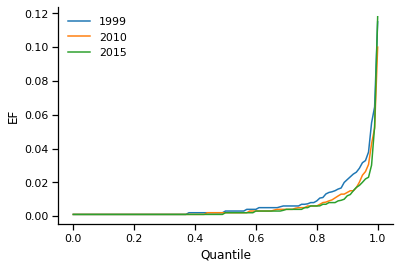

In [191]:
fig,ax = plt.subplots()
for y in y_list_short :
    df_temp = df[df['year']==y]
    ax.plot(eval_range,df_temp[rank_var].quantile(eval_range),label=y)
sns.despine()
ax.legend(frameon=False)
ax.set_ylabel(rank_var)
ax.set_xlabel('Quantile')

# Mean of top-5 versus mean of the next 10

In [192]:
year_list = df.year.unique()

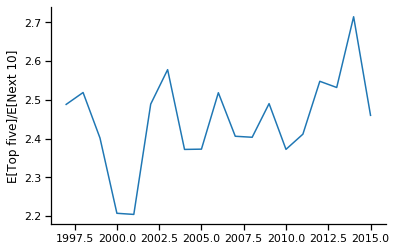

In [193]:
share = []
for y in year_list:
    df_temp = df[df['year']==y][rank_var].sort_values()
    s = df_temp.iloc[-5:].mean()/df_temp.iloc[-15:-5].mean()
    share +=[s]
    
fig,ax = plt.subplots()
ax.plot(year_list,share)
ax.set_ylabel("E[Top five]/E[Next 10]")
sns.despine()

# Compared to other fields

In [194]:
field_dict = {'economics':'GY',
              'sociology':'XA',
              'political science': "UU",
              'psychology':'VI',
             'anthropology':'BF'}

Load data

In [195]:
df_a = pd.DataFrame()
for field in field_dict:
    for year in range(1997,2015+1):
        df_temp = get_data(year,field_dict[field])
        df_temp['year'] = year
        df_temp['field'] = field
        df_a = df_a.append(df_temp)
    

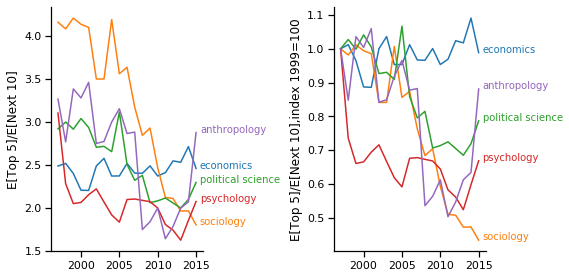

In [196]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(8,4))

for field in field_dict:
    share = []
    for y in year_list:
        df_temp = df_a[(df_a['year']==y) & (df_a['field']==field)].sort_values(rank_var)[rank_var]
        s = df_temp.iloc[-5:].mean()/df_temp.iloc[-15:-5].mean()
        share +=[s]


    l = ax.plot(year_list,share,label=field)
    ax.text(year_list[-1]+.5,share[-1],field,color=l[0].get_color())
    
    l = ax2.plot(year_list,share/share[0],label=field)
    ax2.text(year_list[-1]+.5,share[-1]/share[0],field,color=l[0].get_color())
    
ax.set_ylabel("E[Top 5]/E[Next 10]")
ax2.set_ylabel("E[Top 5]/E[Next 10],index 1999=100")
sns.despine()

fig.tight_layout()


In [197]:
df_a.to_csv('EF.csv',index=False)